In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import inv
from itertools import product
from port_solver import portfolio_optimization
from ipca_utils import impute_w_median, normalize, IPCA_factor


#### Read Raw Data and Preprocess

In [11]:
fn = "data/kelly_data_without_nanocap.p"
df = pd.read_pickle(fn)
cols_to_drop = ["isin", "cusip", "sedol", "excntry", "ret_local", "ret_exc"]
df = df.drop(cols_to_drop, axis=1)
df = df.dropna(subset=['ret_local_lead1m'])

characteristics = df.columns[6:] #list of characteristics
df_ipca = impute_w_median(df, characteristics)
df_ipca = normalize(df_ipca, characteristics)

pd.set_option("display.max_column", None)
df.head(10)

,id,eom,ret_exc_lead1m,ret_local_lead1m,niq_su,ret_6_1,ret_12_1,saleq_su,tax_gr1a,ni_inc8q,prc_highprc_252d,resff3_6_1,resff3_12_1,be_me,debt_me,at_me,ret_60_12,ni_me,fcf_me,div12m_me,eqpo_me,eqnpo_me,sale_gr3,sale_gr1,ebitda_mev,sale_me,ocf_me,ival_me,bev_mev,netdebt_me,eq_dur,capex_abn,at_gr1,ppeinv_gr1a,noa_at,noa_gr1a,lnoa_gr1a,capx_gr1,capx_gr2,capx_gr3,chcsho_12m,eqnpo_12m,debt_gr3,inv_gr1,inv_gr1a,oaccruals_at,taccruals_at,cowc_gr1a,coa_gr1a,col_gr1a,nncoa_gr1a,ncoa_gr1a,ncol_gr1a,nfna_gr1a,sti_gr1a,lti_gr1a,fnl_gr1a,be_gr1a,oaccruals_ni,taccruals_ni,netis_at,eqnetis_at,dbnetis_at,niq_be,niq_be_chg1,niq_at,niq_at_chg1,ebit_bev,ebit_sale,sale_bev,at_turnover,gp_at,gp_atl1,ope_be,ope_bel1,op_at,op_atl1,cop_at,cop_atl1,f_score,o_score,z_score,pi_nix,at_be,saleq_gr1,rd_me,rd_sale,opex_at,emp_gr1,rd5_at,age,dsale_dinv,dsale_drec,dgp_dsale,dsale_dsga,sale_emp_gr1,tangibility,kz_index,ocfq_saleq_std,cash_at,ni_ar1,ni_ivol,earnings_variability,aliq_at,aliq_mat,seas_1_1an,seas_1_1na,seas_2_5an,seas_2_5na,seas_6_10an,seas_6_10na,seas_11_15an,seas_11_15na,seas_16_20an,seas_16_20na,market_equity,ivol_ff3_21d,ivol_capm_252d,ivol_capm_21d,ivol_hxz4_21d,rvol_21d,beta_60m,betabab_1260d,beta_dimson_21d,turnover_126d,turnover_var_126d,dolvol_126d,dolvol_var_126d,prc,ami_126d,zero_trades_21d,zero_trades_126d,zero_trades_252d,rmax1_21d,rskew_21d,iskew_capm_21d,iskew_ff3_21d,iskew_hxz4_21d,coskew_21d,ret_1_0,betadown_252d,bidaskhl_21d,ret_3_1,ret_9_1,ret_12_7,corr_1260d,rmax5_21d,rmax5_rvol_21d,ni_be,ocf_at,ocf_at_chg1,mispricing_perf,mispricing_mgmt,qmj,qmj_prof,qmj_growth,qmj_safety
0,100100001,1970-09-30,0.059230,0.063830,NaN,NaN,NaN,NaN,0.055691,NaN,NaN,NaN,NaN,0.389696,0.333709,1.095773,NaN,0.077817,-0.613949,NaN,NaN,NaN,8.273810,4.052973,0.147433,1.399905,-0.425303,1.022609,0.525045,0.284973,16.828861,-0.021824,3.848362,2.787572,2.823370,2.191658,0.138015,1.048487,26.461111,40.889831,NaN,NaN,6.091646,10.403599,0.281903,0.452041,0.237322,0.312587,0.505851,0.193264,0.139454,0.222834,0.083380,-0.214719,NaN,0.032843,0.251010,0.266091,7.349377,3.858437,NaN,NaN,0.251010,0.060123,NaN,0.052671,NaN,0.222367,0.105129,2.115171,2.159265,0.425118,2.061128,0.434923,1.727343,0.172889,0.838230,-0.279152,-1.353428,6.0,-1.548939,NaN,2.143262,2.81187,0.335870,NaN,NaN,1.129423,NaN,NaN,117,-7.392944,-5.827022,0.736966,-0.389403,NaN,0.626638,NaN,NaN,0.044476,-0.604826,0.060335,0.222692,3.209009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.202500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.179708,-0.388130,-0.166415,NaN,NaN,NaN,NaN,NaN,NaN
1,100100001,1970-10-31,-0.284600,-0.280000,NaN,NaN,NaN,NaN,0.055691,NaN,NaN,NaN,NaN,0.366314,0.313686,1.030027,NaN,0.080072,-0.577112,NaN,NaN,NaN,8.273810,4.052973,0.140456,1.288395,-0.399785,0.961253,0.500198,0.267874,16.979129,-0.021824,3.848362,2.787572,2.823370,2.191658,0.138015,1.048487,26.461111,40.889831,NaN,NaN,6.091646,10.403599,0.281903,0.452041,0.237322,0.312587,0.505851,0.193264,0.139454,0.222834,0.083380,-0.214719,NaN,0.032843,0.251010,0.266091,7.349377,3.858437,NaN,NaN,0.251010,NaN,NaN,NaN,NaN,0.222367,0.105129,2.115171,2.159265,0.425118,2.061128,0.434923,1.727343,0.172889,0.838230,-0.279152,-1.353428,6.0,-1.548939,NaN,2.143262,2.81187,-0.071796,NaN,NaN,1.129423,NaN,NaN,118,-7.392944,-5.827022,0.736966,-0.389403,NaN,0.626638,NaN,NaN,0.044476,-0.604826,0.060335,0.222692,3.209009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.875000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.179708,-0.388130,-0.166415,0.557225,0.007569,-0.131257,-0.242119,1.131001,-1.038514
2,100100001,1970-11-30,0.106911,0.111111,NaN,NaN,NaN,NaN,0.055691,NaN,NaN,NaN,NaN,0.508769,0.435675,1.430593,NaN,0.111211,-0.801545,NaN,NaN,NaN,8.273810,4.052973,0.180267,1.789437,-0.555257,1.335073,0.641973,0.372048,16.063606,-0.021824,3.848362,2.787572,2.823370,2.191658,0.

#### Read Preprocessed Data

In [2]:
df_ipca = pd.read_csv('data/factor_data_qnormed.csv')
characteristics = df_ipca.columns[6:] #list of characteristics
pd.set_option("display.max_column", None)
df_ipca.head(10)

,eom,id,ret_exc_lead1m,ret_local_lead1m,ret_local,ret_exc,niq_su,ret_6_1,ret_12_1,saleq_su,tax_gr1a,ni_inc8q,prc_highprc_252d,resff3_6_1,resff3_12_1,be_me,debt_me,at_me,ret_60_12,ni_me,fcf_me,div12m_me,eqpo_me,eqnpo_me,sale_gr3,sale_gr1,ebitda_mev,sale_me,ocf_me,ival_me,bev_mev,netdebt_me,eq_dur,capex_abn,at_gr1,ppeinv_gr1a,noa_at,noa_gr1a,lnoa_gr1a,capx_gr1,capx_gr2,capx_gr3,chcsho_12m,eqnpo_12m,debt_gr3,inv_gr1,inv_gr1a,oaccruals_at,taccruals_at,cowc_gr1a,coa_gr1a,col_gr1a,nncoa_gr1a,ncoa_gr1a,ncol_gr1a,nfna_gr1a,sti_gr1a,lti_gr1a,fnl_gr1a,be_gr1a,oaccruals_ni,taccruals_ni,netis_at,eqnetis_at,dbnetis_at,niq_be,niq_be_chg1,niq_at,niq_at_chg1,ebit_bev,ebit_sale,sale_bev,at_turnover,gp_at,gp_atl1,ope_be,ope_bel1,op_at,op_atl1,cop_at,cop_atl1,f_score,o_score,z_score,pi_nix,at_be,saleq_gr1,rd_me,rd_sale,opex_at,emp_gr1,rd5_at,age,dsale_dinv,dsale_drec,dgp_dsale,dsale_dsga,sale_emp_gr1,tangibility,kz_index,ocfq_saleq_std,cash_at,ni_ar1,ni_ivol,earnings_variability,aliq_at,aliq_mat,seas_1_1an,seas_1_1na,seas_2_5an,seas_2_5na,seas_6_10an,seas_6_10na,seas_11_15an,seas_11_15na,seas_16_20an,seas_16_20na,market_equity,ivol_ff3_21d,ivol_capm_252d,ivol_capm_21d,ivol_hxz4_21d,rvol_21d,beta_60m,betabab_1260d,beta_dimson_21d,turnover_126d,turnover_var_126d,dolvol_126d,dolvol_var_126d,prc,ami_126d,zero_trades_21d,zero_trades_126d,zero_trades_252d,rmax1_21d,rskew_21d,iskew_capm_21d,iskew_ff3_21d,iskew_hxz4_21d,coskew_21d,ret_1_0,betadown_252d,bidaskhl_21d,ret_3_1,ret_9_1,ret_12_7,corr_1260d,rmax5_21d,rmax5_rvol_21d,ni_be,ocf_at,ocf_at_chg1,mispricing_perf,mispricing_mgmt,qmj,qmj_prof,qmj_growth,qmj_safety
0,1962-01-31,100104301,-0.039478,-0.037478,NaN,NaN,NaN,NaN,NaN,NaN,0.276667,NaN,NaN,NaN,NaN,0.076667,0.156667,0.050000,NaN,0.113333,0.653333,NaN,NaN,NaN,0.623333,0.420000,0.106667,0.080000,0.333333,0.060000,0.103333,0.343333,0.936667,0.336667,0.430000,0.626667,0.366667,0.703333,0.270000,0.170000,0.376667,0.740000,NaN,NaN,0.770000,0.656667,0.720000,0.703333,0.726667,0.773333,0.666667,0.233333,0.253333,0.293333,0.206667,0.333333,NaN,0.423333,0.676667,0.730000,0.353333,0.660000,NaN,NaN,0.680000,NaN,NaN,NaN,NaN,0.800000,0.776667,0.563333,0.570000,0.906667,0.886667,0.806667,0.783333,0.893333,0.883333,0.880000,0.866667,0.738333,0.140000,NaN,0.863333,0.170000,NaN,0.036667,0.073333,0.560000,0.773333,0.056667,1.000000,0.223333,0.396667,0.700000,0.643333,0.193333,0.650000,NaN,NaN,0.566667,0.103333,0.160000,0.210000,0.686667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.840000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.906667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.783333,0.460000,0.840000,NaN,NaN,NaN,NaN,NaN,NaN
1,1962-01-31,100113301,0.051937,0.053937,NaN,NaN,NaN,NaN,NaN,NaN,0.053333,NaN,NaN,NaN,NaN,0.500000,0.536667,0.966667,NaN,0.020000,0.180000,NaN,NaN,NaN,0.256667,0.130000,0.016667,0.973333,0.360000,0.500000,0.980000,0.100000,0.500000,0.310000,0.050000,0.080000,0.500000,0.498333,0.093333,0.216667,0.310000,0.260000,NaN,NaN,0.030000,0.150000,0.130000,0.500000,0.498333,0.113333,0.040000,0.080000,0.498333,0.182906,0.498333,0.583333,NaN,0.783333,0.620000,0.498333,0.498333,0.498333,NaN,NaN,0.613333,NaN,NaN,NaN,NaN,0.016667,0.023333,0.820000,0.726667,0.333333,0.270000,0.500000,0.500000,0.016667,0.016667,0.500000,0.498333,0.161667,0.500000,NaN,0.500000,0.500000,NaN,0.498333,0.498333,0.840000,0.203333,0.500000,1.000000,0.776667,0.803333,0.143333,0.073333,0.220000,0.130000,NaN,NaN,0.403333,0.030000,0.786667,0.906667,0.190000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.133333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.310000,0.246667,NaN,NaN,NaN,NaN,NaN,NaN
2,1962-01-31,100115701,0.062263,0.064263,NaN,NaN,NaN,NaN,NaN,NaN,0.796667,NaN,NaN,NaN,NaN,0.500000,0.000000,0.266667,NaN,0.150000,0.770000,NaN,NaN,NaN,0.963333,0.806667,0.226667,0.606667,0.660000,0.500000,0.133333,0.336667,0.500000,0.103333,0.930000,0.650000,0

In [3]:
df_ipca['betadown_252d']

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
2456671    0.878441
2456672    0.320081
2456673    0.101301
2456674    0.119604
2456675    0.378930
Name: betadown_252d, Length: 2456676, dtype: float64

## IPCA Parameters

In [5]:
from logger import ErrorLogger
from tqdm import tqdm
from datetime import datetime

In [6]:
window_size = 240 #rolling window size
K = 6 #num of principle components
unique_dates = sorted(df_ipca['eom'].unique()) #unique dates
T = len(unique_dates)

current_date = datetime.now().strftime('%Y-%m-%d')
# log_fp = "logs/"+f"{current_date}-w{window_size}-log-error.txt"
res_fp = "results/"+f"{current_date}-w{window_size}-results.csv"
logger = ErrorLogger() #each node/window has separate log file

print (f'There are {T} unique days starting with {unique_dates[0]}')
print (f'Total {len(characteristics)} charateristics starting with {characteristics[0]}')

There are 745 unique days starting with 1962-01-31
Total 153 charateristics starting with niq_su


In [6]:
problem_date = '1992-11-30'
for t in range(window_size, T):
    if unique_dates[t] == problem_date:
        print (t)
        break  

370


In [11]:
np.random.seed(102)

t = 380
K = 6
    
window_dates = unique_dates[t-window_size:t]
window_data = df_ipca[df_ipca['eom'].isin(window_dates)]
date_to_predict = unique_dates[t]

print (f'======Progress: {t}: {date_to_predict}======')

# calculate ipca
try:
    Gamma, Factors, r_t, excess_r_t, X_last, beta = IPCA_factor(window_data, characteristics, K)
except Exception as e:
    raise

# regularization
V_t = inv(Gamma.T @ X_last.T @ X_last @ Gamma) @ Gamma.T @ X_last.T
reg_mat = np.zeros_like(V_t)
reg_mat[:K, :K] = np.eye(K)*1e-05
V_t += reg_mat

Sigma_t= np.cov(Factors, rowvar = True)
mu_t = np.array(np.mean(Factors, axis=1))

# Grid search? grid search for regularization terms
g1 = np.exp(np.linspace( np.log(1e-6),np.log(5),10))
g2 = np.exp(np.linspace( np.log(1e-6),np.log(5),10))

#set up progress bar
total_interations = len(g1)*len(g2)

with tqdm(total=total_interations, desc='Lambda Reg Progress') as pbar:
    for lambda1, lambda2 in product(g1, g2):
        ws = portfolio_optimization(
            meanVec=np.array(mu_t),
            sigMat=np.array(Sigma_t),
            retTarget=0,
            longShort=0.2,
            maxAlloc=0.08, #
            lambda_l1=lambda1,
            lambda_l2=lambda2,
            riskfree=0,
            assetsOrder=None,
            maxShar=1,
            factor=np.array(V_t.T)[:,:],
            turnover=None,
            w_pre=None,
            individual=False,
            exposure_constrain=0,
            w_bench=None,
            factor_exposure_constrain=None,
            U_factor=None,
            general_linear_constrain=None,
            U_genlinear=0,
            w_general=None,
            TE_constrain=0,
            general_quad=0,
            Q_w=None,
            Q_b=None,
            Q_bench=None
        )

        ret_t = (V_t.T @ ws).T @ r_t
        pbar.update(1)
        
        print (ret_t)
       
        break


           
    

======Progress: 380: 1993-09-30======


The panel dimensions are:
n_samples: 6773 , L: 122 , T: 239


[========================================================================] 100%
Lambda Reg Progress:   0%|          | 0/100 [00:00<?, ?it/s]

     pcost       dcost       gap    pres   dres
 0:  2.5978e-01  4.8336e+00  3e+04  2e+02  2e+03
 1:  7.9667e-01 -4.8177e+03  8e+03  3e+01  2e+02
 2:  1.1807e+00 -4.6199e+02  7e+02  2e+00  2e+01
 3:  1.8852e+00 -3.1018e+01  6e+01  4e-01  3e+00
 4:  2.6625e+00 -1.3667e+01  2e+01  9e-02  8e-01
 5:  2.6846e+00 -1.7578e+00  5e+00  2e-02  2e-01
 6:  2.4898e+00  4.4297e-02  3e+00  9e-03  8e-02
 7:  2.3951e+00  6.6340e-01  2e+00  6e-03  5e-02
 8:  2.2862e+00  1.2709e+00  1e+00  3e-03  3e-02
 9:  2.2248e+00  1.5983e+00  6e-01  2e-03  1e-02
10:  2.1696e+00  1.8798e+00  3e-01  7e-04  6e-03
11:  2.1504e+00  1.9791e+00  2e-01  3e-04  3e-03
12:  2.1338e+00  2.0622e+00  7e-02  1e-04  9e-04
13:  2.1244e+00  2.1093e+00  2e-02  2e-05  1e-04
14:  2.1226e+00  2.1179e+00  5e-03  2e-06  2e-05
15:  2.1219e+00  2.1216e+00  3e-04  1e-07  1e-06


Lambda Reg Progress:   1%|          | 1/100 [01:28<2:26:25, 88.74s/it]

16:  2.1218e+00  2.1218e+00  3e-06  2e-09  1e-08
Optimal solution found.
maximum
[0.00125853]
long
1.1999998914647443
positive
1.1999999999523352
negative
0.19999999995230142
kappa
[33.95754359]
0    0.036811
dtype: float64


### Result Analysis
#### Sharpe Ratio


In [3]:
res = pd.read_csv('/gpfs/home/zilinchen/ipca_factor_portfolio/results/2024-04-01-w240-results.csv')
res['Sum_Positive_Weights'].describe()

count    505.000000
mean       1.547896
std        0.285723
min        1.154659
25%        1.318810
50%        1.444560
75%        1.752435
max        2.387502
Name: Sum_Positive_Weights, dtype: float64

In [9]:
mean_exc_ret = np.mean(res['P_Excess_Return'])
std_ret = np.std(res['P_Return'])
print(f"Average Excess Return: {mean_exc_ret}")
print(f"Annualized Sharpe: {mean_exc_ret/std_ret*np.sqrt(12)}")

Average Excess Return: 0.018690170916966595
Annualized Sharpe: 1.3348056278705034


#### Turnover

Average Monthly Turnover: 1.4988830074440291


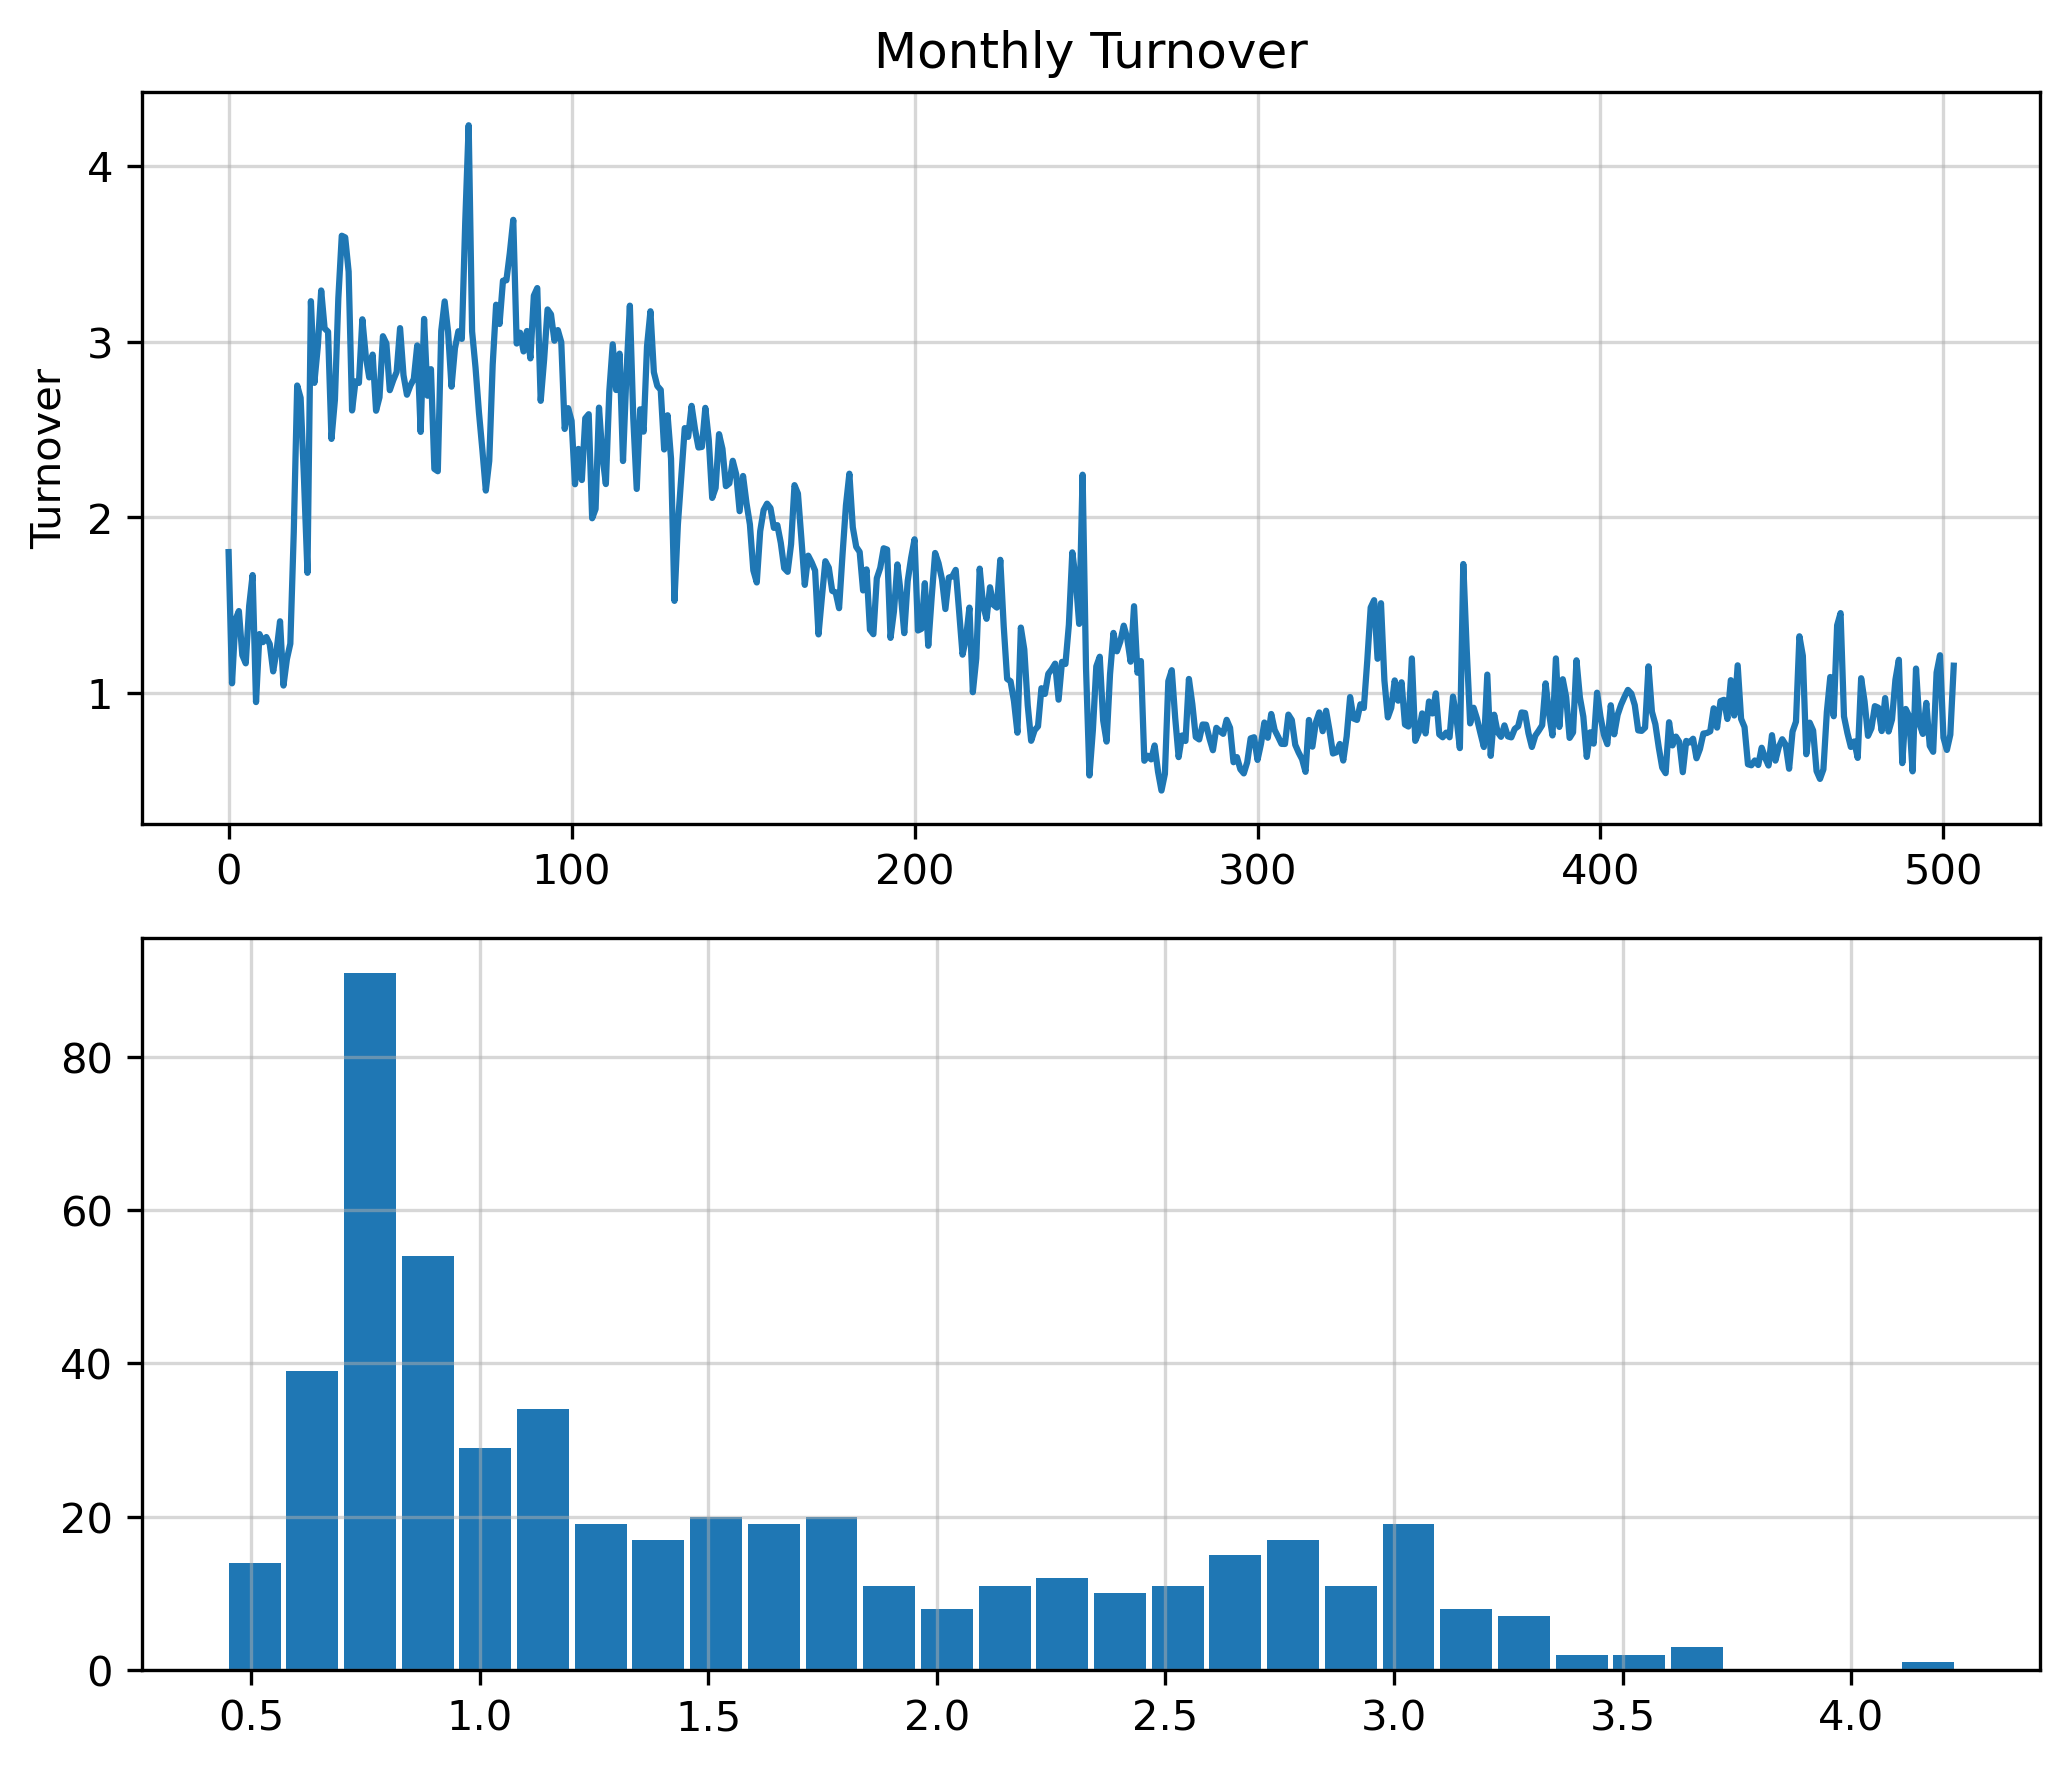

In [32]:
import os
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [7,6]

def calc_monthly_turnover(
    df_pre: pd.DataFrame, 
    df_cur: pd.DataFrame
):
    """
    df_pre: Pandas Dataframe containing previous month weights
    df_cur: Pandas Dataframe containing current month weights
    """
    df_merged = pd.merge(df_pre, df_cur, on='ID', how='outer', suffixes=('_pre', '_cur'))
    df_merged.fillna(0, inplace=True)
    df_merged['Abs_Weight_Change'] = (df_merged['Weights_cur'] - df_merged['Weights_pre']).abs()
    
    return np.sum(df_merged['Abs_Weight_Change'])


# Read in weights files
weights_fps = []
folder_path = "results/individual_weights"
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    weights_fps.append(file_path)

weights_fps = sorted(weights_fps)

# Calculate monthly Turnovers
monthly_turnovers = []
for i in range(1, len(weights_fps)):
    pre_w = pd.read_csv(weights_fps[i-1])
    cur_w = pd.read_csv(weights_fps[i])
    
    turnover = calc_monthly_turnover(pre_w, cur_w)
    monthly_turnovers.append(turnover)
    

print (f'Average Monthly Turnover: {np.mean(monthly_turnovers)}')

_, axes = plt.subplots(nrows=2, ncols=1, dpi=300)

axes[0].plot(monthly_turnovers)
axes[0].set_ylabel("Turnover")
axes[0].set_title("Monthly Turnover")
axes[0].grid(alpha=0.5)

axes[1].hist(monthly_turnovers,rwidth=0.9, bins=30)
axes[1].grid(alpha=0.5)

plt.tight_layout()